## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
import scvelo as scv
import cellrank as cr
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

## Load Segmentoid velocity

In [2]:
adata = sc.read('data/sample_3_segmentoid_72h_velo_originalmatrix.h5ad')

## Pre process

In [3]:
sc.pp.filter_cells(adata, min_counts=4000)
sc.pp.filter_cells(adata, max_counts=65000)
sc.pp.filter_cells(adata, min_genes=3000)
sc.pp.filter_cells(adata, max_genes=8000)

In [4]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

In [5]:
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
adata = adata[adata.obs['pct_counts_mito'] < 10, :]

In [6]:
adata.raw = adata

In [7]:
sc.pp.normalize_total(adata)

In [8]:
sc.pp.log1p(adata)

In [9]:
sc.pp.highly_variable_genes(adata, n_top_genes=1750)

In [10]:
sc.pp.regress_out(adata, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'phase' as categorical


In [11]:
sc.pp.scale(adata)

In [12]:
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [13]:
sc.tl.umap(adata)

In [14]:
sc.tl.leiden(adata, resolution=.4, key_added='clusters')

In [15]:
adata.obs['clusters'] = adata.obs['clusters'].replace(['0'],'PSM')
adata.obs['clusters'] = adata.obs['clusters'].replace(['1'],'Somite')
adata.obs['clusters'] = adata.obs['clusters'].replace(['2'],'Somite')
adata.obs['clusters'] = adata.obs['clusters'].replace(['3'],'Somite')
adata.obs['clusters'] = adata.obs['clusters'].replace(['4'],'Somite')
adata.obs['clusters'] = adata.obs['clusters'].replace(['5'],'NMP/Neural')

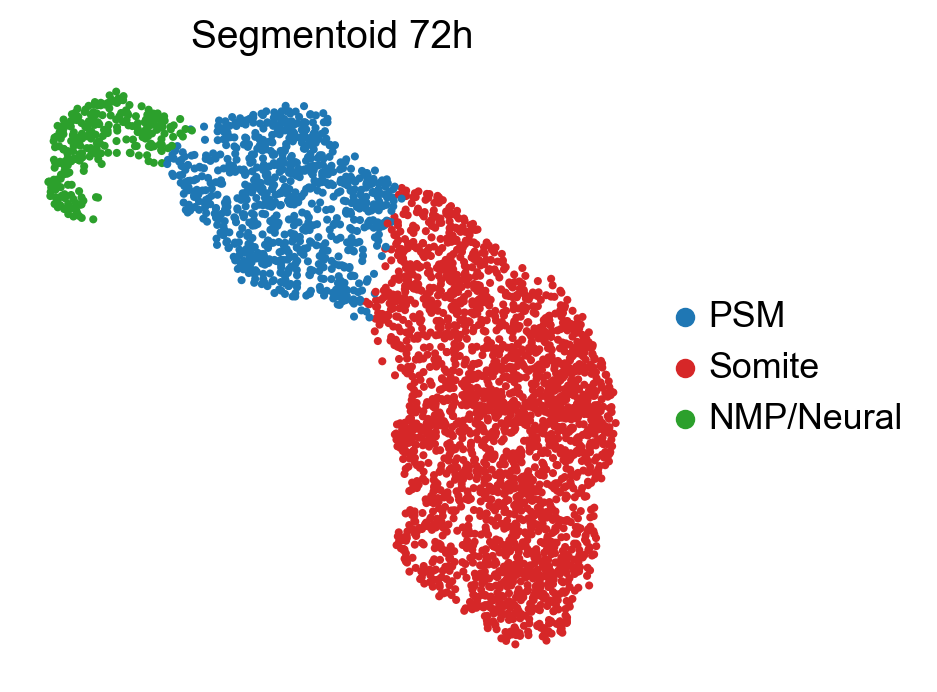

In [16]:
sc.pl.umap(adata, color=['clusters'], title='Segmentoid 72h', palette=['tab:blue', 'tab:red', 'tab:green'])

## NMP/NEURAL SPLIT - LEIDEN CORRECTION

In [17]:
tmp = adata[adata.obs['clusters'].isin(['NMP/Neural']),:]
adata_sc = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,uns=tmp.uns,obsm=tmp.obsm,obsp=tmp.obsp,layers=tmp.layers)

In [18]:
adata_sc.raw = adata_sc

In [19]:
sc.tl.umap(adata_sc)

In [20]:
sc.tl.leiden(adata_sc, resolution=.5, key_added='leiden_sc')

In [21]:
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['0'],'NMP')
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['1'],'NMP')
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['2'],'NMP')
adata_sc.obs['leiden_sc'] = adata_sc.obs['leiden_sc'].replace(['3'],'Neural')

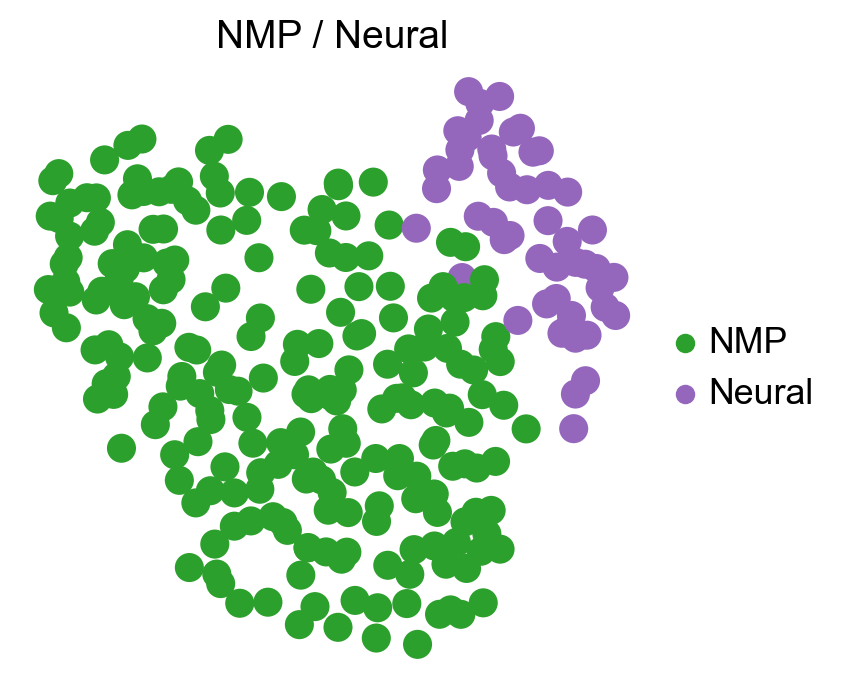

In [22]:
sc.pl.umap(adata_sc, color=['leiden_sc'], title='NMP / Neural', palette=['tab:green', 'tab:purple'])

## Reinjection

In [23]:
obs = adata_sc.obs_names.to_list()

In [24]:
tmp=adata[~adata.obs_names.isin(obs),:]
adata_bis = sc.AnnData(tmp.raw.X,obs=tmp.obs,var=tmp.raw.var,layers=tmp.layers)

In [25]:
tmp_2=adata_sc
adata_sc2 = sc.AnnData(tmp_2.raw.X,obs=tmp_2.obs,var=tmp_2.raw.var,layers=tmp_2.layers)
adata_sc2.obs['clusters']=adata_sc2.obs['leiden_sc']

In [26]:
adata_injected = adata_sc2.concatenate(adata_bis, batch_key='batch_layer_2')

## Identical preprocess

In [27]:
cell_cycle_genes = [x.strip() for x in open('utils/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata_injected.var_names]
sc.tl.score_genes_cell_cycle(adata_injected, s_genes=s_genes, g2m_genes=g2m_genes)

In [28]:
adata_injected.raw = adata_injected

In [29]:
sc.pp.normalize_total(adata_injected)

In [30]:
sc.pp.log1p(adata_injected)

In [31]:
sc.pp.highly_variable_genes(adata_injected, n_top_genes=1500)

In [32]:
sc.pp.regress_out(adata_injected, ['S_score', 'G2M_score'], n_jobs = 16)

... storing 'phase' as categorical
... storing 'clusters' as categorical


In [33]:
sc.pp.scale(adata_injected)

In [34]:
scv.pp.moments(adata_injected, n_pcs=30, n_neighbors=20)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [35]:
sc.tl.umap(adata_injected)

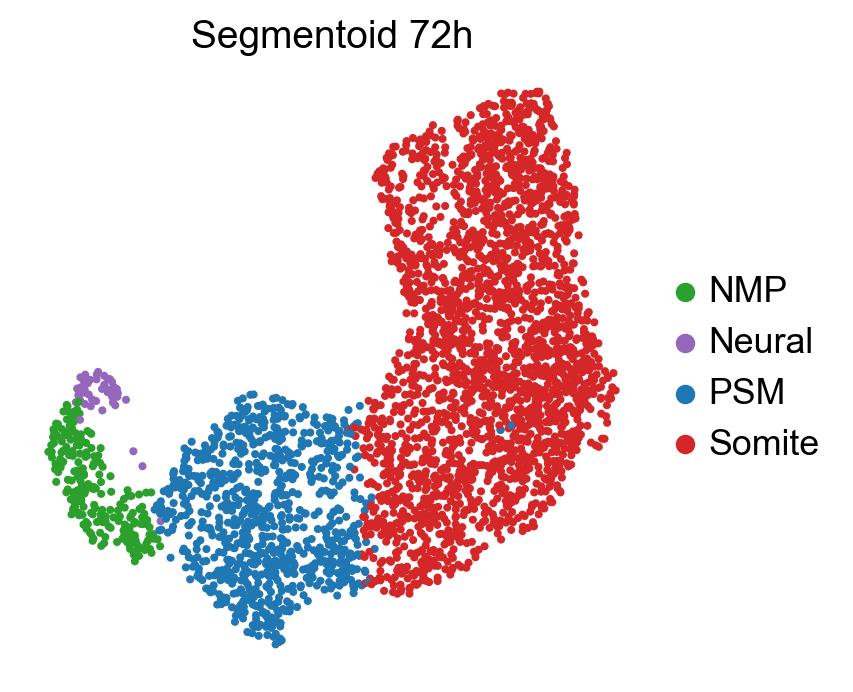

In [57]:
sc.pl.umap(adata_injected, color=['clusters'], title='Segmentoid 72h', palette=['tab:green', 'tab:purple', 'tab:blue', 'tab:red'])

## Differential Kinetics

In [37]:
var_names = ['POU5F1', 'NKX1-2', 'TBXT', 'HES7', 'TBX6', 'DLL1', 'MESP2', 'RIPPLY2', 'TCF15', 'MEOX1', 'MYOCD', 'PAX3', 'UNCX', 'TBX18', 'MSX1']
scv.tl.differential_kinetic_test(adata_injected, var_names=var_names, groupby='clusters')

recovering dynamics (using 1/16 cores)


  0%|          | 0/15 [00:00<?, ?gene/s]

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:09) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
testing for differential kinetics
    finished (0:00:01) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


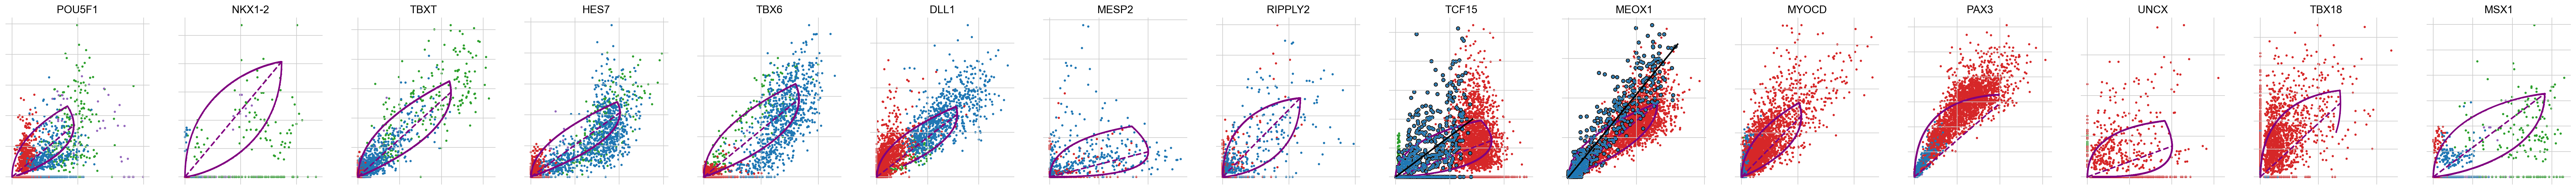

In [38]:
kwargs = dict(linewidth=2, add_linfit=True, frameon=False)
scv.pl.scatter(adata_injected, basis=var_names, add_outline='fit_diff_kinetics', **kwargs)

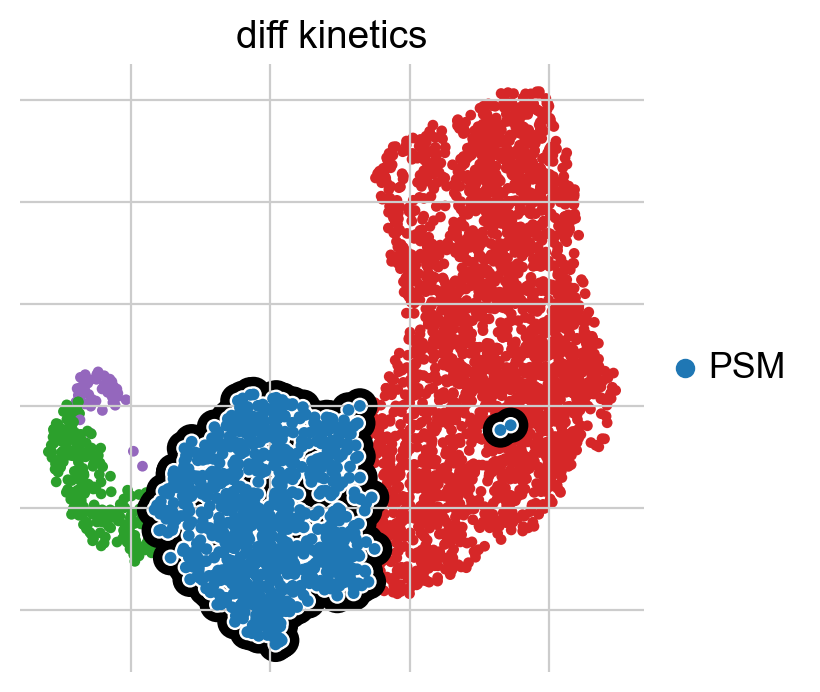

In [39]:
diff_clusters=list(adata_injected[:, var_names].var['fit_diff_kinetics'])
scv.pl.scatter(adata_injected, legend_loc='right', size=60, title='diff kinetics', add_outline=diff_clusters, outline_width=(.8, .2))

In [40]:
scv.tl.recover_dynamics(adata_injected, n_jobs=16)

recovering dynamics (using 16/16 cores)


  0%|          | 0/556 [00:00<?, ?gene/s]

    finished (0:01:32) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [41]:
top_genes = adata_injected.var['fit_likelihood'].sort_values(ascending=False).index[:100]
scv.tl.differential_kinetic_test(adata_injected, var_names=top_genes, groupby='clusters')

testing for differential kinetics
    finished (0:00:09) --> added 
    'fit_diff_kinetics', clusters displaying differential kinetics (adata.var)
    'fit_pvals_kinetics', p-values of differential kinetics (adata.var)


## Recompute velocities

In [42]:
scv.tl.recover_dynamics(adata_injected, n_jobs=16)

recovering dynamics (using 16/16 cores)


  0%|          | 0/556 [00:00<?, ?gene/s]

    finished (0:01:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\tools\dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [43]:
scv.tl.velocity(adata_injected, mode='dynamical', diff_kinetics=True)
scv.tl.velocity_graph(adata_injected)

computing velocities
    finished (0:00:18) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3539 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scvelo\core\_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


saving figure to file ./figures/scvelo_velocity_72h.svg


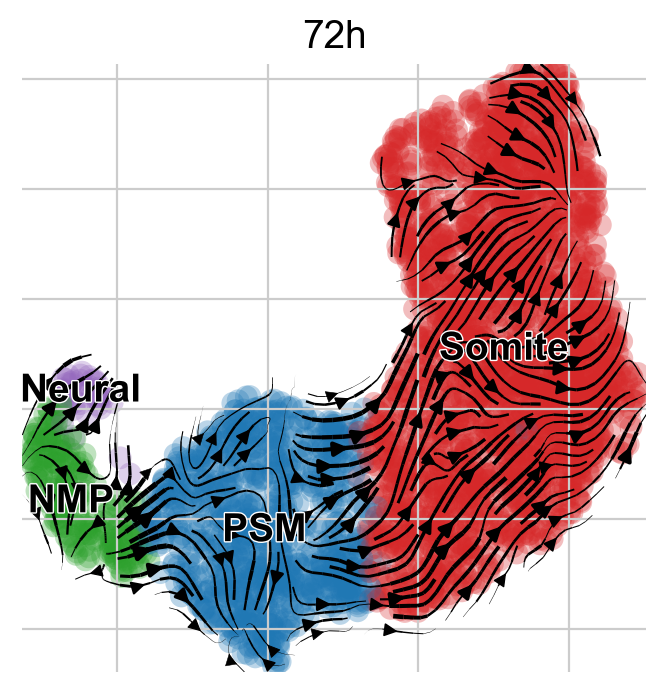

In [51]:
scv.pl.velocity_embedding_stream(adata_injected, basis='umap', title='72h', save='velocity_72h.svg')

In [45]:
adata_injected.uns['neighbors']['distances'] = adata_injected.obsp['distances']
adata_injected.uns['neighbors']['connectivities'] = adata_injected.obsp['connectivities']

scv.tl.paga(adata_injected, groups='clusters')
df = scv.get_df(adata_injected, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,NMP,Neural,PSM,Somite
NMP,0,0.11,0.21,0
Neural,0,0,0,0
PSM,0,0,0,0.16
Somite,0,0,0,0


saving figure to file ./figures/scvelo_velocitypaga_72h.svg


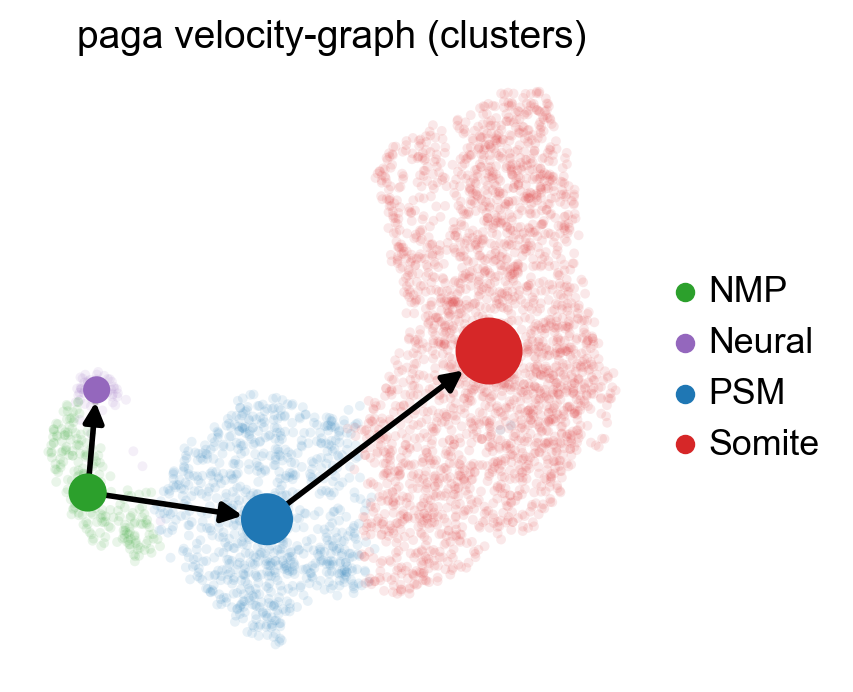

In [3]:
scv.pl.paga(adata_injected, basis='umap', size=50, alpha=.1, min_edge_width=2, node_size_scale=1.5, save='velocitypaga_72h.svg')

In [58]:
adata_injected.obs['timepoint'] = '72h'
adata_injected.write('data/sample_1_segmentoid_72h_velo_processed.h5ad')

... storing 'timepoint' as categorical


In [2]:
adata_injected=sc.read('data/sample_1_segmentoid_72h_velo_processed.h5ad')